In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import warnings

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

# 1. Load the data and basic analysis

In [3]:
# Read raw dataset
days = pd.read_csv("../data/days_cleaned.csv", index_col=0)
days.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
# Pass the Date to index as we will use timeseries to analyze the data
days.index = pd.to_datetime(days.dteday)

In [5]:
# Confirm the index is now of type datetime
days.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq=None)

In [6]:
# Check the first 5 rows of the dataset 
days.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


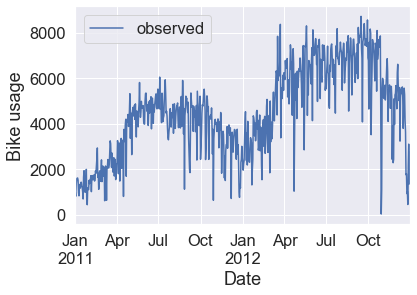

In [7]:
# Plot cnt (number of bike rides) as a function of the date
sns.set(font_scale=1.5)
ax = days["cnt"].iloc[:731].plot(label='observed')
ax.set_xlabel('Date')
ax.set_ylabel('Bike usage')
plt.legend()

plt.show()

## 1.a Using a month lag

At first a lag of 30 days is tried to do a decomposition of the data in order to see if the data is repeated every month.

c:\users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """


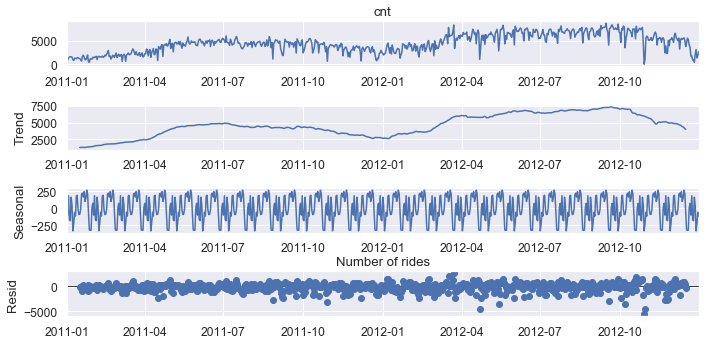

In [8]:
# Decomposition of the time serie. As the variation in the trend is more linear than exponential I apply an additive 
# decomposition
sns.set(font_scale=1.1)
plt.rcParams["figure.figsize"] = [10, 5]
decomposed = sm.tsa.seasonal_decompose(days['cnt'], model="additive", freq=30)
decomposed_plot = decomposed.plot()

plt.title('Number of rides')

plt.show()

In order to analyse one wants to use a SARIMA model.
But in order to be able to use SARIMA we need to check for Stationarity. One can do that using the Augmented Dickey Fuller test.

Hypotheses:

𝐻𝑂 : The data is not stationary

𝐻𝐴 : The data is stationary

In [9]:
# Perform Augmented Dickey Fuller on cnt
adfuller(days['cnt'])

(-1.8774481444374302,
 0.3427434403392191,
 13,
 717,
 {'1%': -3.439503230053971,
  '5%': -2.8655794463678346,
  '10%': -2.5689210707289982},
 11740.390931163352)

In [10]:
# Print the p value of the test
adfuller(days['cnt'])[1]

0.3427434403392191

We can't disprove the null hypothesis H0 because the p value is superior to 0.05 so our data is not stationary.
In order to apply the ARIMA method we need stationary data. In order to transform our data we will use Differencing.

We can use differencing many times untill we find that our data is stationary. The amount of time we apply differencing will give us the d (for differencing) value we need to input in the ARIMA (p,d,q) model.

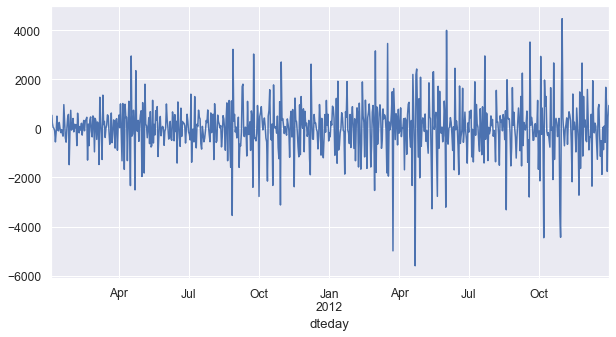

In [11]:
# Perform differencing on the data for the first time
days['cnt_diff'] = days['cnt'] - days['cnt'].shift(1)
days['cnt_diff'].dropna().plot()

In [12]:
# Perform Augmented Dickey Fuller on cnt_diff and print the p value of the test 
# I use dropna as the test can't be performed if there are some Nan's in the column
adfuller(days['cnt_diff'].dropna())[1]

1.0467797548020037e-21

This time we can reject the null hypothesis. Now we can say that the data is stationary after 1 differencing. Therefore we can use the ARIMA model with d=1.
In order to help me choose the other coefficients of the ARIMA model I'm going to plot the autocorrelation and partial autosorrelation functions for the differenced column cnt_diff

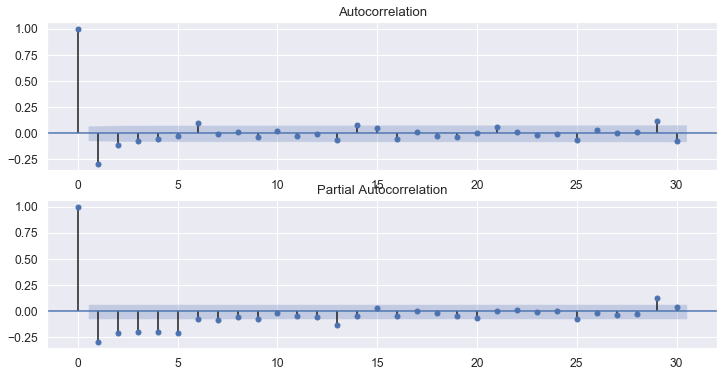

In [13]:
 from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt_diff.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(days.cnt_diff.dropna(), ax=ax[1], lags=30)

I also plot the ones for cnt as a comparison

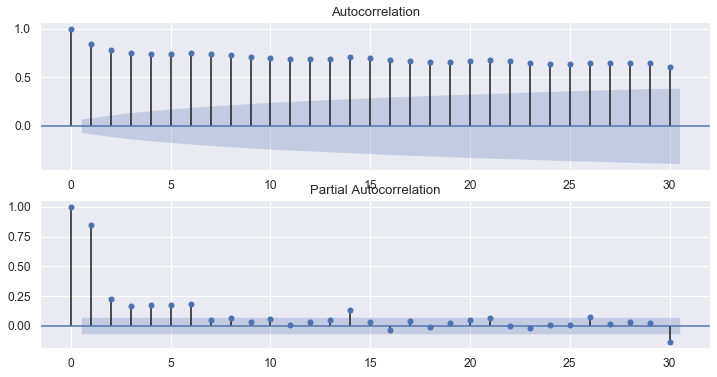

In [14]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(days.cnt.dropna(), ax=ax[1], lags=30)

## 1.b Using a week lag

It probably makes more sense to use a lag of 7 (i.e. to compare weekdays) instead of a lag of 30 days. Indeed it seems more logical that the bike usage would repeat itself every Monday compared to repeating itself every first of the month.

So I'll do the same as above with lag = 7.

c:\users\asus\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """


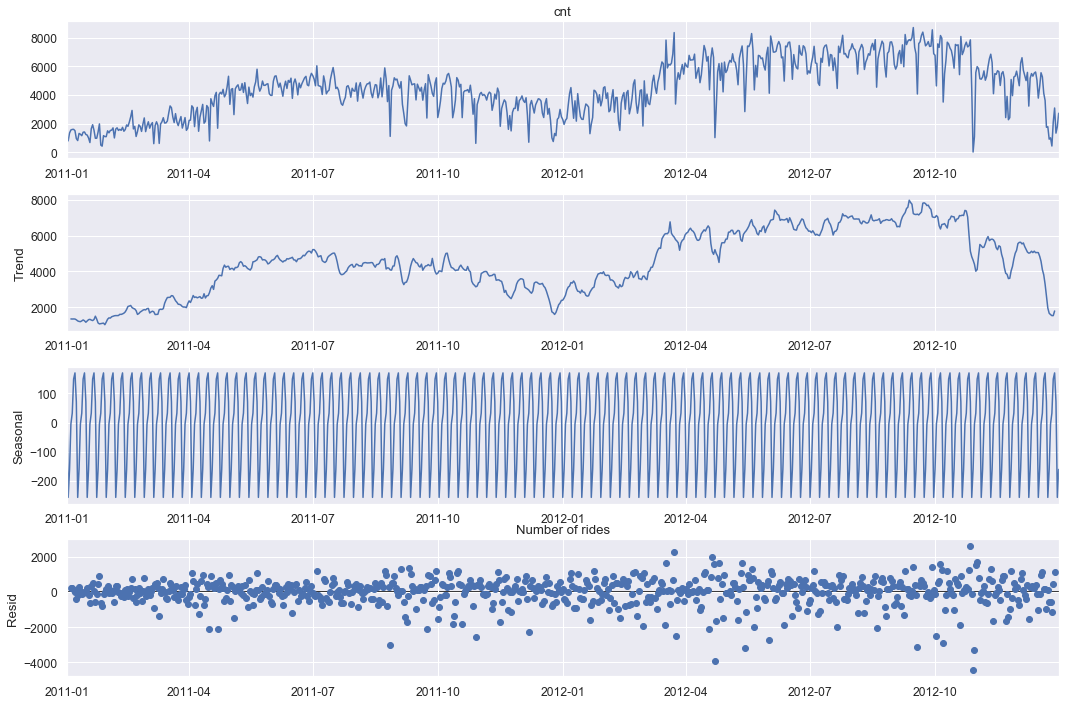

In [15]:
# Decomposition of the time serie. As the variation in the trend is more linear than exponential I apply an additive 
# decomposition with a lag (called freq) of 7
sns.set(font_scale=1.1)
plt.rcParams["figure.figsize"] = [15, 10]
decomposed = sm.tsa.seasonal_decompose(days['cnt'], model="additive", freq=7)
decomposed_plot = decomposed.plot()

plt.title('Number of rides')

plt.show()

I want to apply the SARIMA model and I will need to determine the value of p,d,q,P,D,Q and m in ARIMA(p,d,q)(P,D,Q)m

I will start by determining the values for d and D that I will obtain by counting the number of differencing if any I need to apply to the data and seasonal data before it becomes stationary.

Using the work done with the month lag we already know that by applying one differencing the data is stationary so one can assume d = 1.


To determine the other parameters of the ARIMA model I plot the autocorrelation and partial autocorrelation functions ACF and PACF for a lag = 7

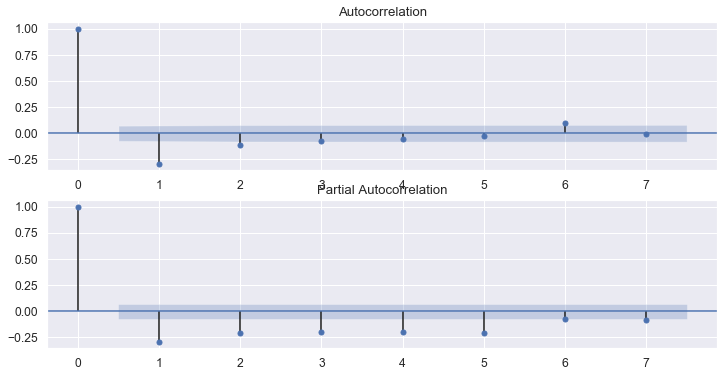

In [16]:
# Plot ACF and PACF for lag 7
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt_diff.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(days.cnt_diff.dropna(), ax=ax[1], lags=7)

As we have a strong positive autocorrelation at lag-1 and a sharp decrease after that, it means that we should choose p=1. So far we have defined that we need an ARIMA(1,1,0) 


I also want to determine P,D and Q. D will be the number of differencing applied to the seasonal data (with lag 7)

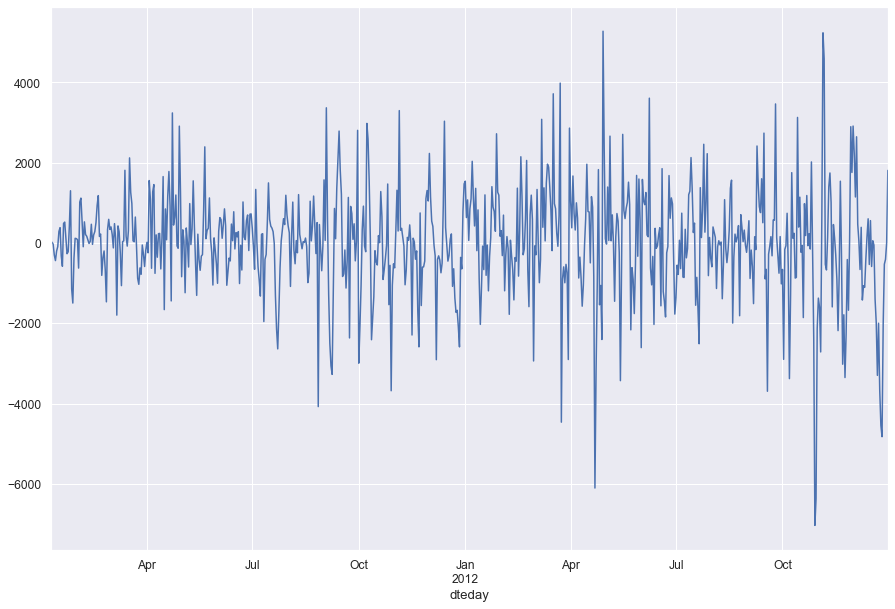

In [17]:
# Perform differencing on the data for 7 days (lag of a week)
days['cnt_diff7'] = days['cnt'] - days['cnt'].shift(7)
days['cnt_diff7'].dropna().plot()

In [18]:
# Perform Augmented Dickey Fuller on cnt_diff and print the p value of the test 
adfuller(days['cnt_diff7'].dropna())[1]

3.0128464762631004e-12

As the p-value is inferiror to 0.05 we can say that the data is stationary and D = 1.

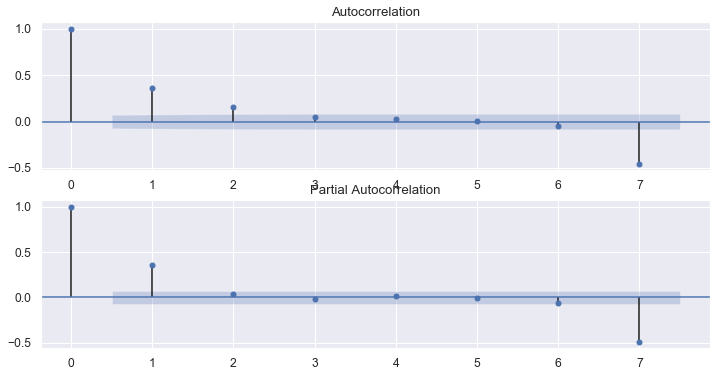

In [19]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(days.cnt_diff7.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(days.cnt_diff7.dropna(), ax=ax[1], lags=7)

This ACF and PACF model suggest an AR type model (as the autocorrelation is positive and decaying towards 0) of 1 as there is a sharp decline after lag-1

In the end by combining what we found earlier for p,d,q in ARIMA we suggest a model SARIMA with the parameters SARIMA(1,1,0)(1,1,0)7

# 2. SARIMA model analysis

## 2.a. Using Grid Search with loop

I'll first define the training and test set. I choose all the data except the last month.

In [20]:
# Determine the total number of rows I have 
days.shape

(731, 18)

In [21]:
# I remove 31 days to the total number of rows to create the training set. So I will take until index number 700. 
# The test set is made of the remainder of the dataset
train, test = days.iloc[:700], days.iloc[701:]

In [22]:
# specify training data
data = train["cnt"]
# define model configuration
my_order = (1, 1, 0)
my_seasonal_order = (1, 1, 0, 7)
# define model
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [23]:
# Fit the model
model_fit = model.fit()

In [24]:
# Calculate the Aikeke Information Criterion AIC for this specific model
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               cnt   No. Observations:                  700
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -5897.025
Date:                           Wed, 19 Feb 2020   AIC                          11800.050
Time:                                   09:11:36   BIC                          11813.669
Sample:                               01-01-2011   HQIC                         11805.317
                                    - 11-30-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3175      0.031    -10.192      0.000      -0.379      -0.256
ar.S.L7       -0.5348      0.024    -22.705

The AIC for our selected hyperparameters is 11784.

Now we will do a Grid Search to try to find out what are the best parameters to select for SARIMA.

The first step is to create all the possible combinations of parameters we will try.

The second step is to calculate the AIC for every combination of parameters. The model with the lowest AIC is the one we will select as the best model.

In [25]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [94]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:13852.406672403242
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:13309.549907229612
ARIMA(0, 0, 0)x(0, 0, 2, 7)7 - AIC:12581.48169113193
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:11882.046397266713
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:11529.554675361904
ARIMA(0, 0, 0)x(0, 1, 2, 7)7 - AIC:11411.430568695698
ARIMA(0, 0, 0)x(0, 2, 0, 7)7 - AIC:12501.725478381539
ARIMA(0, 0, 0)x(0, 2, 1, 7)7 - AIC:11705.436138859202
ARIMA(0, 0, 0)x(0, 2, 2, 7)7 - AIC:11425.335669406846
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:11890.105844505768
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:11643.43449612367
ARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:11525.548379563688
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:11607.645768247809
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:11524.957012002324
ARIMA(0, 0, 0)x(1, 1, 2, 7)7 - AIC:11408.442199065288
ARIMA(0, 0, 0)x(1, 2, 0, 7)7 - AIC:12002.983292614295
ARIMA(0, 0, 0)x(1, 2, 1, 7)7 - AIC:11507.052180231192
ARIMA(0, 0, 0)x(1, 2, 2, 7)7 - AIC:11371.99721892575
ARIMA(0, 0, 0)x(2, 0, 0, 7)7 - 

ARIMA(0, 1, 2)x(2, 0, 0, 7)7 - AIC:11291.078649595383
ARIMA(0, 1, 2)x(2, 0, 1, 7)7 - AIC:11286.888715129062
ARIMA(0, 1, 2)x(2, 0, 2, 7)7 - AIC:11241.996057983004
ARIMA(0, 1, 2)x(2, 1, 0, 7)7 - AIC:11314.020516723202
ARIMA(0, 1, 2)x(2, 1, 1, 7)7 - AIC:11186.606102555807
ARIMA(0, 1, 2)x(2, 1, 2, 7)7 - AIC:11139.562025730502
ARIMA(0, 1, 2)x(2, 2, 0, 7)7 - AIC:11599.15112946231
ARIMA(0, 1, 2)x(2, 2, 1, 7)7 - AIC:11231.705880253176
ARIMA(0, 1, 2)x(2, 2, 2, 7)7 - AIC:11113.014505164248
ARIMA(0, 2, 0)x(0, 0, 0, 7)7 - AIC:12348.41303205183
ARIMA(0, 2, 0)x(0, 0, 1, 7)7 - AIC:12230.06879250698
ARIMA(0, 2, 0)x(0, 0, 2, 7)7 - AIC:12111.760326695208
ARIMA(0, 2, 0)x(0, 1, 0, 7)7 - AIC:12744.553867050774
ARIMA(0, 2, 0)x(0, 1, 1, 7)7 - AIC:12127.509606499909
ARIMA(0, 2, 0)x(0, 1, 2, 7)7 - AIC:12107.322355220309
ARIMA(0, 2, 0)x(0, 2, 0, 7)7 - AIC:13393.633010912421
ARIMA(0, 2, 0)x(0, 2, 1, 7)7 - AIC:12520.082350091885
ARIMA(0, 2, 0)x(0, 2, 2, 7)7 - AIC:11933.555047576076
ARIMA(0, 2, 0)x(1, 0, 0, 7)7 - 

ARIMA(1, 0, 2)x(1, 0, 0, 7)7 - AIC:11404.511890662037
ARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:11372.218711486956
ARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:11259.730250156474
ARIMA(1, 0, 2)x(1, 1, 0, 7)7 - AIC:11493.025098579812
ARIMA(1, 0, 2)x(1, 1, 1, 7)7 - AIC:11368.377769047262
ARIMA(1, 0, 2)x(1, 1, 2, 7)7 - AIC:11211.685684820708
ARIMA(1, 0, 2)x(1, 2, 0, 7)7 - AIC:11907.162355020562
ARIMA(1, 0, 2)x(1, 2, 1, 7)7 - AIC:11377.830827153843
ARIMA(1, 0, 2)x(1, 2, 2, 7)7 - AIC:11535.889950285946
ARIMA(1, 0, 2)x(2, 0, 0, 7)7 - AIC:11294.402158308014
ARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:11290.727910453272
ARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:11261.42432926056
ARIMA(1, 0, 2)x(2, 1, 0, 7)7 - AIC:11306.380964412767
ARIMA(1, 0, 2)x(2, 1, 1, 7)7 - AIC:11186.389586512501
ARIMA(1, 0, 2)x(2, 1, 2, 7)7 - AIC:11240.758626261157
ARIMA(1, 0, 2)x(2, 2, 0, 7)7 - AIC:11585.015695218175
ARIMA(1, 0, 2)x(2, 2, 1, 7)7 - AIC:11220.864762994257
ARIMA(1, 0, 2)x(2, 2, 2, 7)7 - AIC:11657.339445303913
ARIMA(1, 1, 0)x(0, 0, 0, 7)7 

ARIMA(1, 2, 2)x(0, 0, 0, 7)7 - AIC:11486.886316524426
ARIMA(1, 2, 2)x(0, 0, 1, 7)7 - AIC:11397.355706311748
ARIMA(1, 2, 2)x(0, 0, 2, 7)7 - AIC:11266.305509900178
ARIMA(1, 2, 2)x(0, 1, 0, 7)7 - AIC:11786.335873739066
ARIMA(1, 2, 2)x(0, 1, 1, 7)7 - AIC:11422.517121058203
ARIMA(1, 2, 2)x(0, 1, 2, 7)7 - AIC:11308.740768816975
ARIMA(1, 2, 2)x(0, 2, 0, 7)7 - AIC:12403.594105435974
ARIMA(1, 2, 2)x(0, 2, 1, 7)7 - AIC:11895.874163303617
ARIMA(1, 2, 2)x(0, 2, 2, 7)7 - AIC:11692.847221740181
ARIMA(1, 2, 2)x(1, 0, 0, 7)7 - AIC:11409.350386359774
ARIMA(1, 2, 2)x(1, 0, 1, 7)7 - AIC:11379.578810306022
ARIMA(1, 2, 2)x(1, 0, 2, 7)7 - AIC:11267.885404247692
ARIMA(1, 2, 2)x(1, 1, 0, 7)7 - AIC:11559.44322157553
ARIMA(1, 2, 2)x(1, 1, 1, 7)7 - AIC:11423.45778410915
ARIMA(1, 2, 2)x(1, 1, 2, 7)7 - AIC:11308.373592953449
ARIMA(1, 2, 2)x(1, 2, 0, 7)7 - AIC:12041.196922154588
ARIMA(1, 2, 2)x(1, 2, 1, 7)7 - AIC:11844.179325245681
ARIMA(1, 2, 2)x(1, 2, 2, 7)7 - AIC:11693.650297480128
ARIMA(1, 2, 2)x(2, 0, 0, 7)7 -

ARIMA(2, 1, 1)x(2, 0, 0, 7)7 - AIC:11261.8659423717
ARIMA(2, 1, 1)x(2, 0, 1, 7)7 - AIC:11252.827197490715
ARIMA(2, 1, 1)x(2, 0, 2, 7)7 - AIC:11260.014436654103
ARIMA(2, 1, 1)x(2, 1, 0, 7)7 - AIC:11273.091350870382
ARIMA(2, 1, 1)x(2, 1, 1, 7)7 - AIC:11154.164788804357
ARIMA(2, 1, 1)x(2, 1, 2, 7)7 - AIC:11154.206742473973
ARIMA(2, 1, 1)x(2, 2, 0, 7)7 - AIC:11558.153464576997
ARIMA(2, 1, 1)x(2, 2, 1, 7)7 - AIC:11350.43687068712
ARIMA(2, 1, 1)x(2, 2, 2, 7)7 - AIC:11659.37996555957
ARIMA(2, 1, 2)x(0, 0, 0, 7)7 - AIC:11457.45663517165
ARIMA(2, 1, 2)x(0, 0, 1, 7)7 - AIC:11368.054287791141
ARIMA(2, 1, 2)x(0, 0, 2, 7)7 - AIC:11241.059862169108
ARIMA(2, 1, 2)x(0, 1, 0, 7)7 - AIC:11768.351460711543
ARIMA(2, 1, 2)x(0, 1, 1, 7)7 - AIC:11355.493093935633
ARIMA(2, 1, 2)x(0, 1, 2, 7)7 - AIC:11304.069081628213
ARIMA(2, 1, 2)x(0, 2, 0, 7)7 - AIC:12341.807231936626
ARIMA(2, 1, 2)x(0, 2, 1, 7)7 - AIC:11871.489869168672
ARIMA(2, 1, 2)x(0, 2, 2, 7)7 - AIC:11667.593754528101
ARIMA(2, 1, 2)x(1, 0, 0, 7)7 - AI

The settings with the lowest AIC are below:

ARIMA(1, 1, 1)x(0, 2, 2, 7)7 - AIC:11089.634892601633

ARIMA(2, 1, 1)x(0, 2, 2, 7)7 - AIC:11090.945525176723

I select ARIMA ARIMA(1, 1, 1)x(0, 2, 2, 7)7 to plot the prediction compared to reality

In [26]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 1, 1),
                                seasonal_order=(0, 2, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3245      0.036      8.931      0.000       0.253       0.396
ma.L1         -0.9068      0.020    -45.347      0.000      -0.946      -0.868
ma.S.L7       -2.0699      0.034    -61.508      0.000      -2.136      -2.004
ma.S.L14       1.0703      0.038     28.460      0.000       0.997       1.144
sigma2      7.524e+05   9.72e-08   7.74e+12      0.000    7.52e+05    7.52e+05


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 

The P>|z| column informs us of the significance of each feature weight. 

Each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.


Let's plot a summary of statistics to ensure that we didn't violate any of the assumptions made by the model.

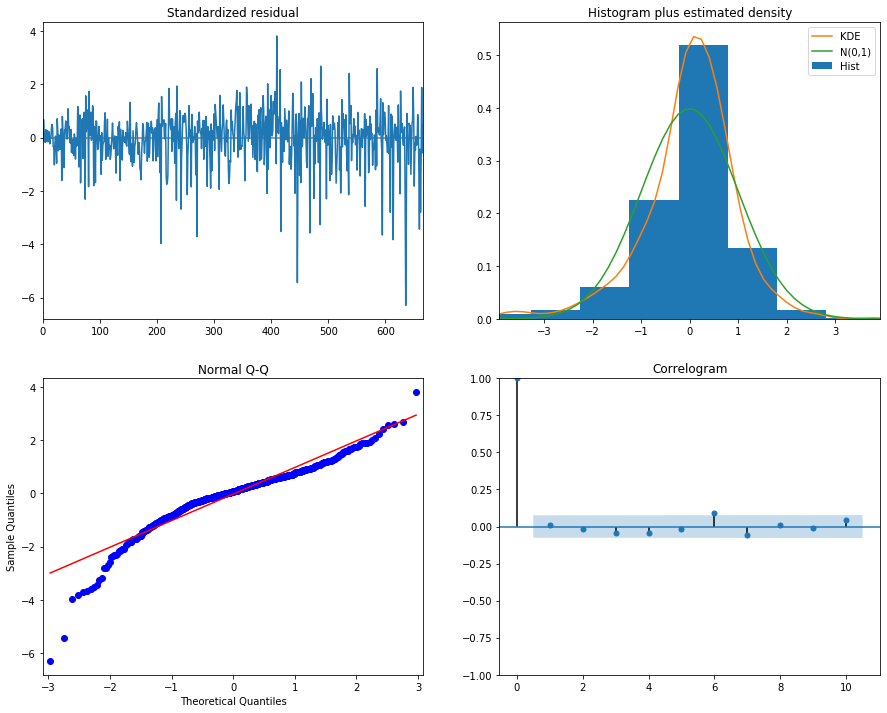

In [130]:
# Plot a summary of the statistics for this model with the selected hyperparameters.
results.plot_diagnostics(figsize=(15, 12))
plt.show()

We want to check that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.


1. In the top right plot, we see that the red KDE line doesn't follow completely the N(0,1) (the standard notation for a normal distribution with mean 0 and standard deviation of 1). 

2. The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1) but not perfectly. This shows that the residuals are not perfectly normally distributed.

3. The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Because of points 1 and 2 we can see that our model could be further improved.

Nevertheless let's see how this model performs.

First one can check how the prediction performs compared to the train dataset

In [27]:
pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

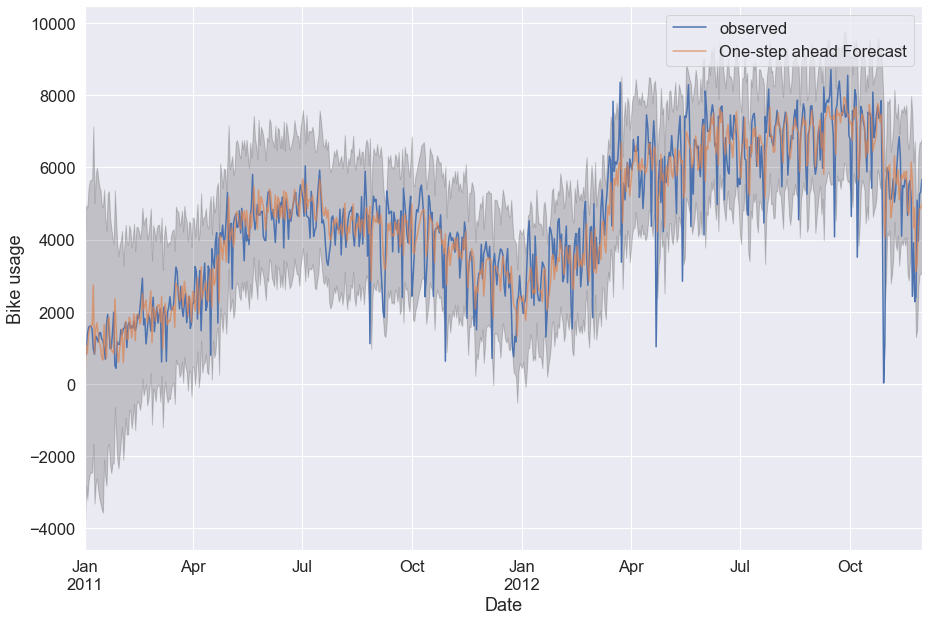

In [28]:
# Plot the prediction (One Step ahead forecast) vs the observed (= data used for training) with the confidence interval
sns.set(font_scale=1.5)
ax = days["cnt"].iloc[:700].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bike usage')
plt.legend()

plt.show()

In order to determine the error we can calculate the Root Mean Square Error between the observed and predicted curve.

In [29]:
error = rmse(days["cnt"].iloc[:700], pred.predicted_mean)

In [30]:
error

938.4856583554173

We can also try to calculate the Mean Absolute Percentage Error (MAPE)

In [230]:
# Define a function to calculate the Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(x, y): 
    y_true, y_pred = np.array(x), np.array(y)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [240]:
# Calculation of MAPE for the previous graph
y_forecasted = pred.predicted_mean
y_observed = days["cnt"].iloc[0:700]

mean_absolute_percentage_error(y_forecasted, y_observed)

inf

There is a problem with the calculation of MAPE as it gives us an infinite result. This is due to the first number of the y_pred array that is equal to 0.

## 2.b. Forecast of bike usage for the next month

Now that we have checked that our prediction matches the training set, we will see how robust is our model by using the dynamic version of get_prediction (i.e. the prediction of future bike usage starting from a specific date using the training data before that date.)

We will do the following:

1. Forecast the data for the next 30 days by using the dynamic version of get_prediction
2. Plot the forecast compared to the train data we have
3. Forecast for an even longer time and plot this too

In [58]:
# What happens with dynamic forecast with a start date of 2012-09-01
pred_dynamic = results.get_prediction(start='2012-09-01', dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

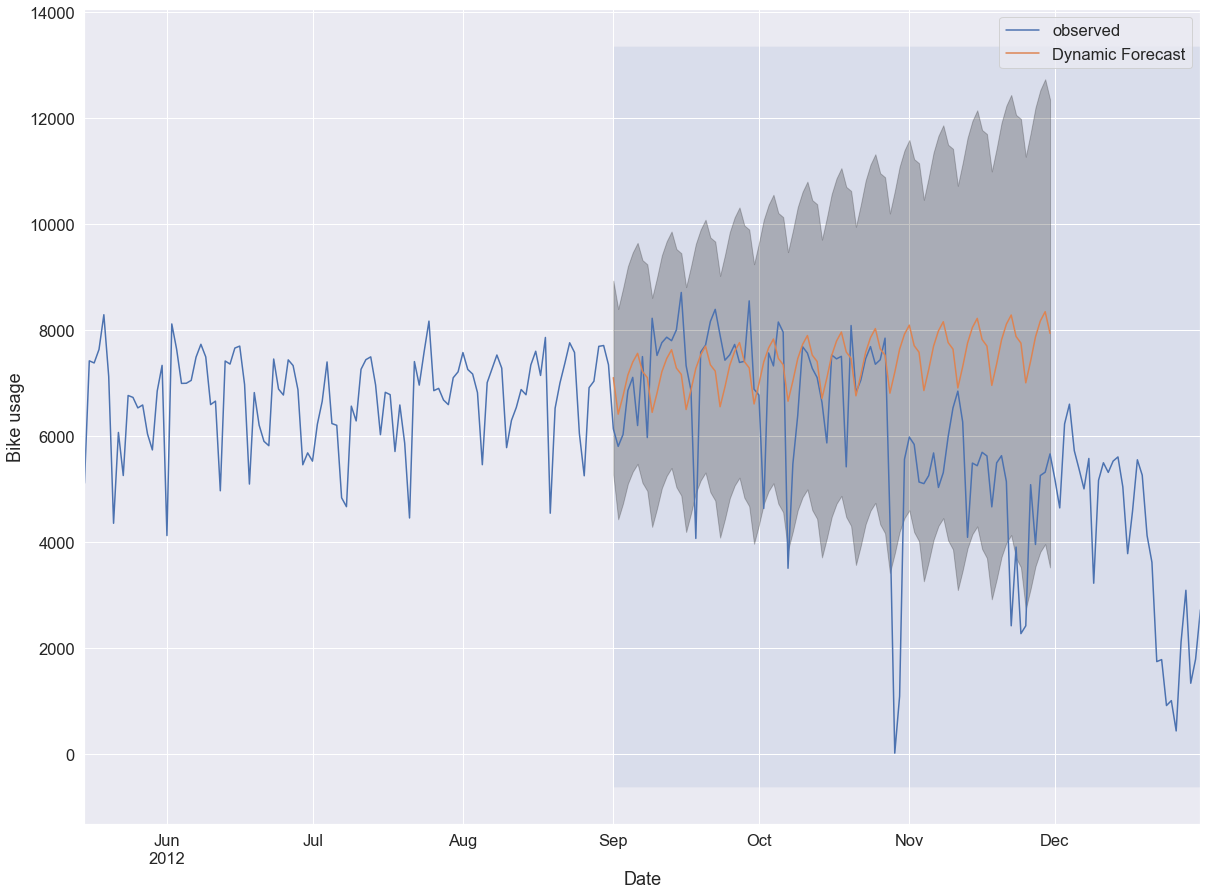

In [64]:
# Plot the prediction (Dynamic forecast) vs the observed (= data used for training) with the confidence interval
sns.set(font_scale=1.5)
ax = days["cnt"].iloc[500:731].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), '2012-09-01', days.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Bike usage')

plt.legend()
plt.show()

It is quite clear that our model is not very robust as the prediction is not very good even for the first two months. It seems to follow the ups and downs of the observed data for the first two months but then it doesn't follow anymore.

This shows that the model and the choice of the hyperparameters need to be improved.

## 2.c. Using the pmdarima package to find the parameters

There is a package called pmdarima that performs a grid search in order to find the best parameters for the ARIMA model.

In [27]:
# Check the length of the dataframe
len(days)

731

In [28]:
# We split the data into training and test by leaving the last month of data for training
train2 = days.iloc[:701]
test2 = days.iloc[701:]

In [ ]:
# Import the pdarima library
import pmdarima
from pmdarima import auto_arima                # for determining ARIMA orders

In [30]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [31]:
# Apply the autoarima to the "cnt" column of the dataframe 
# Note that we use all the available data with the auto_arima. We'll use the train test split later.
auto_arima(days['cnt'], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  731
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -6015.853
Date:                           Wed, 19 Feb 2020   AIC                          12043.706
Time:                                   10:35:59   BIC                          12071.265
Sample:                                        0   HQIC                         12054.338
                                           - 731                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0185      0.453      0.041      0.967      -0.868       0.905
ar.L1          0.3611      0.037      9.874      0.000       0.289       0.433
ma.L1         -0.9025      0.020    -44.099      0.000      -0.943      -0.862
ar.S.L7        0.9340      0.056     16.710      0.000       0.824       1.044
ma.S.L7       -0.8854      0.073    -12.164      0.000      -1.028      -0.743
sigma2      8.392e+05   2.65e+04     31.615      0.000    7.87e+05    8.91e+05
===================================================================================
Ljung-Box (Q):                       45.22   Jarque-Bera (JB):              1128.23
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.89   Skew:                            -1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We fit the model with our train2 and test2 sets

In [32]:
# define the model called model2
model2 = SARIMAX(train2["cnt"], order=(1, 1, 1), seasonal_order=(1, 0, 1, 7), enforce_invertibility=False)

In [34]:
# Fit the model
results2 = model2.fit()

In [35]:
# Check the summary
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               cnt   No. Observations:                  701
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -5763.796
Date:                           Wed, 19 Feb 2020   AIC                          11537.592
Time:                                   10:47:55   BIC                          11560.347
Sample:                               01-01-2011   HQIC                         11546.388
                                    - 12-01-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3333      0.039      8.576      0.000       0.257       0.409
ma.L1         -0.9101      0.021    -42.361      0.000      -0.952      -0.868
ar.S.L7        0.9360      0.067     13.896      0.000       0.804       1.068
ma.S.L7       -0.8879      0.087    -10.204      0.000      -1.058      -0.717
sigma2      9.523e+05   3.06e+04     31.170      0.000    8.92e+05    1.01e+06
===================================================================================
Ljung-Box (Q):                       53.58   Jarque-Bera (JB):              1333.15
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               3.69   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Obtain predicted values
start=len(train2)
end=len(train2)+len(test2)-1
predictions = results2.predict(start,end).rename('SARIMA(1,1,1)(1,0,1,7) Predictions')

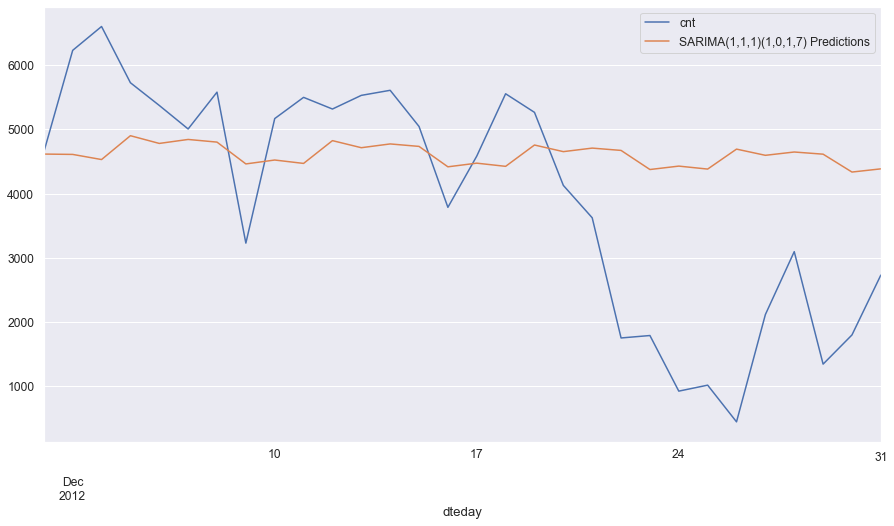

In [41]:
# Plot the test and the prediction for our model
test2['cnt'].plot(legend=True,figsize=(15,8))
predictions.plot(legend=True)

In [44]:
# Determine the rmse of the result
rmse(test2['cnt'], predictions)

1845.9988677204437

In [45]:
# Compare it to the mean of test2
test2['cnt'].mean()

3950.733333333333

The prediction does very bad especially from day number 20 on. This could be due to a combination of Christmas holidays and bad weather.

The next step will be to see if the prediction improves when one uses exogenous variables available like holidays, weekdays and
weather conditions.

# 3. SARIMAX model analysis

When using the SARIMAX model it is possible to include exagenous fields that will influence and hopefully improve the prediction. Let's do this.

In [48]:
# Define the exogenous dataframe that is going to be used in the SARIMAX model
exogenous = days[['holiday','workingday','weathersit']]

In [49]:
exogenous.head()

,holiday,workingday,weathersit
dteday,,,
2011-01-01,0,0,2
2011-01-02,0,0,2
2011-01-03,0,1,1
2011-01-04,0,1,1
2011-01-05,0,1,1


In [50]:
# Apply the autoarima to the "cnt" column of the dataframe 
auto_arima(days['cnt'], exogenous = exogenous, seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  731
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -5918.349
Date:                           Wed, 19 Feb 2020   AIC                          11856.699
Time:                                   13:47:50   BIC                          11902.629
Sample:                               01-01-2011   HQIC                         11874.419
                                    - 12-31-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0291      0.658      0.044      0.965      -1.261       1.319
holiday      -77.5342    165.592     -0.468      0.640    -402.088     247.019
workingday   164.7225    104.759      1.572      0.116     -40.601     370.046
weathersit  -793.6829     48.750    -16.281      0.000    -889.230    -698.136
ar.L1          0.3526      0.037      9.477      0.000       0.280       0.426
ma.L1         -0.8801      0.023    -38.898      0.000      -0.924      -0.836
ar.S.L7        0.8419      0.082     10.222      0.000       0.680       1.003
ar.S.L14       0.0725      0.039      1.840      0.066      -0.005       0.150
ma.S.L7       -0.8445      0.078    -10.781      0.000      -0.998      -0.691
sigma2      6.428e+05   2.13e+04     30.224      0.000    6.01e+05    6.84e+05
===================================================================================
Ljung-Box (Q):                       31.26   Jarque-Bera (JB):               782.00
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
model3 = SARIMAX(train2["cnt"], exog=train2[['holiday','workingday','weathersit']], order=(1, 1, 1), seasonal_order=(2, 0, 1, 7), enforce_invertibility=False)

In [56]:
results3 = model3.fit()

In [57]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               cnt   No. Observations:                  701
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 7)   Log Likelihood               -5669.304
Date:                           Wed, 19 Feb 2020   AIC                          11356.608
Time:                                   13:55:53   BIC                          11397.568
Sample:                               01-01-2011   HQIC                         11372.441
                                    - 12-01-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     -109.2696    194.416     -0.562      0.574    -490.317     271.778
workingday   119.5960    119.181      1.003      0.316    -113.994     353.186
weathersit  -799.0381     56.778    -14.073      0.000    -910.321    -687.755
ar.L1          0.3262      0.040      8.257      0.000       0.249       0.404
ma.L1         -0.8893      0.024    -37.477      0.000      -0.936      -0.843
ar.S.L7        0.8165      0.102      8.029      0.000       0.617       1.016
ar.S.L14       0.0901      0.046      1.945      0.052      -0.001       0.181
ma.S.L7       -0.8339      0.099     -8.417      0.000      -1.028      -0.640
sigma2      7.247e+05   2.79e+04     25.987      0.000     6.7e+05    7.79e+05
===================================================================================
Ljung-Box (Q):                       36.88   Jarque-Bera (JB):               865.02
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
# Define train and set model
start=len(train2)
end=len(train2)+len(test2)-1

In [59]:
# Obtain predicted values
predictions2 = results3.predict(start,end,exog=test2[['holiday','workingday','weathersit']]).rename('SARIMAX(1,1,1)(2,0,1,7) Predictions')

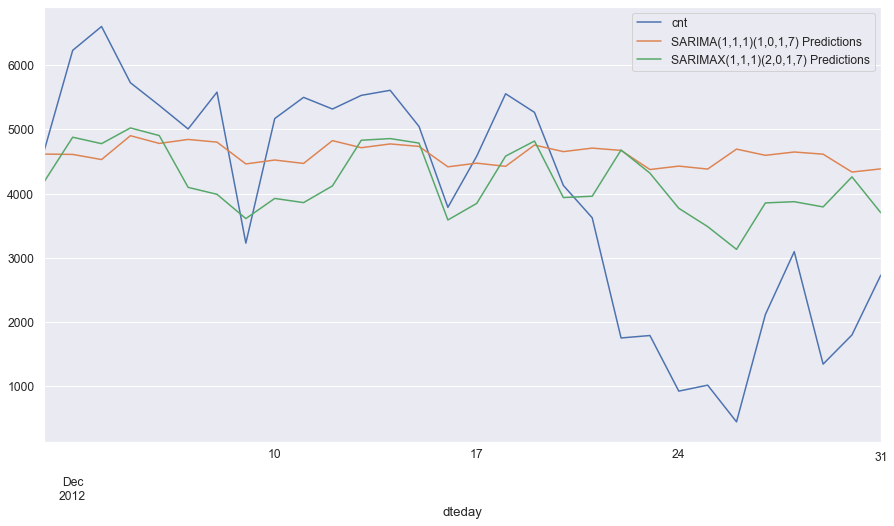

In [60]:
# Plot the test and the prediction for our model
test2['cnt'].plot(legend=True,figsize=(15,8))
predictions.plot(legend=True)
predictions2.plot(legend=True)

In [61]:
# Determine the rmse of the result
rmse(test2['cnt'], predictions2)

1543.3501916304938

Using the exogenous variables brings the prediction closer to the test as the rmse is now lower (1543 instead pf 1845)
And we can actually see on the graph that the green curve gives a better account of the loss of traffic around Christmas time but this is not enough to account for all the traffic loss.